<a href="https://colab.research.google.com/github/sumankmaiti/NIP-Neuron-Label-Inverse-Perturbation/blob/main/NIP_pytorch_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cleverhans

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from absl import app, flags
from easydict import EasyDict
import torchvision
from google.colab.patches import cv2_imshow
import cv2

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

In [ ]:
# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [ ]:
# class VGG(nn.Module):
#     def __init__(self, features, output_dim):
#         super().__init__()

#         self.features = features

#         self.avgpool = nn.AdaptiveAvgPool2d(7)

#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, output_dim),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         h = x.view(x.shape[0], -1)
#         x = self.classifier(h)
#         return x, h

In [ ]:
# vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

# vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
#                 512, 'M']

# vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
#                 'M', 512, 512, 512, 'M']

# vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
#                 512, 512, 'M', 512, 512, 512, 512, 'M']

In [ ]:
# def get_vgg_layers(config, batch_norm):

#     layers = []
#     in_channels = 3

#     for c in config:
#         assert c == 'M' or isinstance(c, int)
#         if c == 'M':
#             layers += [nn.MaxPool2d(kernel_size=2)]
#         else:
#             conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
#             if batch_norm:
#                 layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
#             else:
#                 layers += [conv2d, nn.ReLU(inplace=True)]
#             in_channels = c

#     return nn.Sequential(*layers)

In [ ]:
# vgg19_layers = get_vgg_layers(vgg19_config, batch_norm=False)

In [ ]:
# OUTPUT_DIM = 10

# model = VGG(vgg19_layers, OUTPUT_DIM)

# print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import torchvision.models as models

pretrained_model = models.vgg19(pretrained=True)

print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# IN_FEATURES = pretrained_model.classifier[-1].in_features

# final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
# pretrained_model.classifier[-1] = final_fc
# model.load_state_dict(pretrained_model.state_dict())

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

# train_transforms = transforms.Compose([
#                            transforms.Resize(pretrained_size),
#                            transforms.RandomRotation(5),
#                            transforms.RandomHorizontalFlip(0.5),
#                            transforms.RandomCrop(pretrained_size, padding=10),
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean=pretrained_means,
#                                                 std=pretrained_stds)
                      #  ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
ROOT = '.data'

# train_data = datasets.CIFAR10(ROOT,
#                               train=True,
#                               download=True,
#                               transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified


In [ ]:
# class Sampler():
#     def __init__(self, mask):
#         self.mask = mask

#     def __iter__(self):
#         return (self.indices[i] for i in torch.nonzero(self.mask))

#     def __len__(self):
#         return len(self.mask)

# train_sample = Sampler(1000)
# validation_sample = Sampler(500)
# test_sample = Sampler(500)

In [ ]:
# VALID_RATIO = 0.9

# n_train_examples = int(len(train_data) * VALID_RATIO)
# n_valid_examples = len(train_data) - n_train_examples

# train_data, valid_data = data.random_split(train_data,
#                                            [n_train_examples, n_valid_examples])

In [ ]:
# valid_data = copy.deepcopy(valid_data)
# valid_data.dataset.transform = test_transforms

In [ ]:
# print(f'Number of training examples: {len(train_data)}')
# print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of testing examples: 10000


In [ ]:
BATCH_SIZE = 128

# train_iterator = data.DataLoader(train_data,
#                                  shuffle=True,
#                                  batch_size=BATCH_SIZE)

# valid_iterator = data.DataLoader(valid_data,
#                                  batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [ ]:
# FOUND_LR = 5e-4

# # params = [
# #           {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
# #           {'params': model.classifier.parameters()}
# #          ]

# optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# criterion = nn.CrossEntropyLoss()

# model = model.to(device)
# criterion = criterion.to(device)

In [ ]:
# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim=True)
#     correct = top_pred.eq(y.view_as(top_pred)).sum()
#     acc = correct.float() / y.shape[0]
#     return acc

In [ ]:
# def train(model, iterator, optimizer, criterion, device):

#     epoch_loss = 0
#     epoch_acc = 0

#     model.train()

#     for (x, y) in tqdm(iterator, desc="Training", leave=False):

#         x = x.to(device)
#         y = y.to(device)

#         optimizer.zero_grad()

#         y_pred, _ = model(x)

#         loss = criterion(y_pred, y)

#         acc = calculate_accuracy(y_pred, y)

#         loss.backward()

#         optimizer.step()

#         epoch_loss += loss.item()
#         epoch_acc += acc.item()

#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# def evaluate(model, iterator, criterion, device):

#     epoch_loss = 0
#     epoch_acc = 0

#     model.eval()

#     with torch.no_grad():

#         for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

#             x = x.to(device)
#             y = y.to(device)

#             y_pred, _ = model(x)

#             loss = criterion(y_pred, y)

#             acc = calculate_accuracy(y_pred, y)

#             epoch_loss += loss.item()
#             epoch_acc += acc.item()

#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# EPOCHS = 5

# best_valid_loss = float('inf')

# for epoch in trange(EPOCHS, desc="Epochs"):

#     start_time = time.monotonic()

#     train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
#     valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tut4-model.pt')

#     end_time = time.monotonic()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/vgg19_1000.pt', map_location=torch.device('cpu')))

# test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
def get_predictions(model, iterator):

    model.eval().to(device)

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            # images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    # images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return labels, probs

In [ ]:
# test_iterator.shape
labels, probs = get_predictions(pretrained_model, test_iterator)
pred_labels = torch.argmax(probs, 1)


In [ ]:
print(labels)
print(pred_labels)

tensor([3, 8, 8,  ..., 5, 1, 7])
tensor([3, 8, 8,  ..., 5, 1, 7])


In [ ]:
# def get_representations(model, iterator):

#     model.eval()

#     outputs = []
#     labels = []

#     with torch.no_grad():

#         for (x, y) in tqdm(iterator):

#             x = x.to(device)

#             y_pred, _ = model(x)

#             outputs.append(y_pred.cpu())
#             labels.append(y)

#     outputs = torch.cat(outputs, dim=0)
#     labels = torch.cat(labels, dim=0)

#     return outputs, labels

In [ ]:
# outputs, labels = get_representations(model, train_iterator)

In [ ]:


# class CNN(torch.nn.Module):
#     """Basic CNN architecture."""

#     def __init__(self, in_channels=1):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 8, 1)
#         self.conv2 = nn.Conv2d(64, 128, 6, 2)
#         self.conv3 = nn.Conv2d(128, 128, 5, 2)
#         self.fc = nn.Linear(128 * 3 * 3, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = x.view(-1, 128 * 3 * 3)
#         x = self.fc(x)
#         return x


# def  ld_cifar10 ():
#     """Load training and test data."""
#     train_transforms = torchvision.transforms.Compose(
#         [torchvision.transforms.ToTensor()]
#     )
#     test_transforms = torchvision.transforms.Compose(
#         [torchvision.transforms.ToTensor()]
#     )
#     train_dataset = torchvision.datasets.CIFAR10(
#         root="/tmp/data", train=True, transform=train_transforms, download=True
#     )
#     test_dataset = torchvision.datasets.CIFAR10(
#         root="/tmp/data", train=False, transform=test_transforms, download=True
#     )
#     train_loader = torch.utils.data.DataLoader(
#         train_dataset, batch_size=128, shuffle=True, num_workers=2
#     )
#     test_loader = torch.utils.data.DataLoader(
#         test_dataset, batch_size=128, shuffle=False, num_workers=2
#     )
#     return EasyDict(train=train_loader, test=test_loader)


# def get_perturbed_image(net, data):
    
    # Load training and test data
    # data = ld_cifar10()

    # Instantiate model, loss, and optimizer for training
    # net = CNN(in_channels=3)
device = "cuda" if torch.cuda.is_available() else "cpu"
    # if  device  ==  "miracles" :
        # net  =  net . cuda ()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Train vanilla model
    # net.train().to(device)
    # for epoch in range(1, 15):
        # train_loss = 0.0
        # for x, y in data.train:
            # x, y = x.to(device), y.to(device)
            # if FLAGS.adv_train:
                # Replace clean example with adversarial example for adversarial training
                # x = projected_gradient_descent(net, x, 0.3, 0.01, 40, np.inf)
            # optimizer.zero_grad()
            # loss = loss_fn(net(x), y)
            # loss.backward()
            # optimizer.step()
            # train_loss += loss.item()
        # print(
            # "epoch: {}/{}, train loss: {:.3f}".format(
                # epoch, 60, train_loss
            # )
        # )

    # Evaluate on clean and adversarial data
pretrained_model.eval().to(device)
    # report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
    # images=[]
    # for x, y in data:
    # print(data.test)
x, y = next(iter(test_iterator))

x, y = x.to(device), y.to(device)

x_fgm = fast_gradient_method(pretrained_model, x, 0.3,2)
    # images.append(x_fgm.cpu())
    # print(x_fgm.shape, x.shape)

    # x_pgd = projected_gradient_descent(net, x, 0.3, 0.01, 50, 2)

    
    # f, axarr = plt.subplots(1,3)
    # axarr[0].imshow(x[10].cpu().detach().permute(1, 2, 0))
    # axarr[1].imshow(x_fgm[10].cpu().detach().permute(1, 2, 0))
    # axarr[2].imshow(x_pgd[10].cpu().detach().permute(1, 2, 0))
_, y_pred = model(x).max(1)  # model prediction on clean examples
_, y_pred_fgm = model(x_fgm).max(1)  # model prediction on FGM adversarial examples
    # # _ , y_pred_pgd  =  net ( x_pgd ). max (1)
    #   print("Original label:",y, "\nPredected label without attack:", y_pred, "\nPredected label after FGM attack:" , y_pred_fgm,  "\nPredected label after PGD attack:", y_pred_pgd)
  # return images


# if __name__ == "__main__":
    # flags.DEFINE_integer("nb_epochs", 8, "Number of epochs.")
    # flags.DEFINE_float("eps", 0.3, "Total epsilon for FGM and PGD attacks.")
    # flags.DEFINE_bool(
        # "adv_train", False, "Use adversarial training (on PGD adversarial examples)."
    # )

In [ ]:
print(x_fgm.shape)

torch.Size([32, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


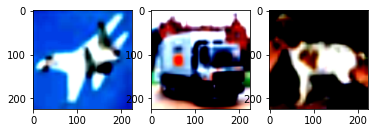

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_fgm[10].cpu().detach().permute(1, 2, 0))
axarr[1].imshow(x_fgm[11].cpu().detach().permute(1, 2, 0))
axarr[2].imshow(x_fgm[12].cpu().detach().permute(1, 2, 0))

In [ ]:
# data = EasyDict(test=data)
adv_data = get_perturbed_image(model, test_iterator)

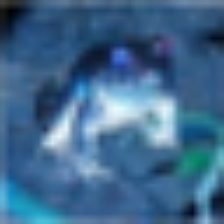

(50, 224, 224, 3)


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

assert train_img.shape == (50, 32, 32, 3)
img = np.empty((50, 224, 224, 3), dtype='float16')
for (k, image) in enumerate(train_img):
    img[k] = cv2.resize(image, dsize=(224, 224))

# img = cv2.resize(x_train, (x_train.shape[0], 224, 224))
cv2_imshow(img[0])
# img = img.reshape(img.shape[0], img.shape[3], img.shape[1], img.shape[2])
print(img.shape)

In [ ]:
# load the model
model = VGG19()
model.summary()

574726144/574710816 [==============================] - 18s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# redefine model to get the output of flatten to last layer
ixs = [22, 23, 24,25]
outputs = [model.layers[i].output for i in ixs]
print(outputs)

[<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc1')>, <KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>, <KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>]


In [ ]:
# calculation of  pertial derivative
import tensorflow as tf
import numpy as np

with tf.GradientTape() as tape:
  # Forward pass
  modified_model = Model(inputs=model.inputs, outputs=outputs)
  x = modified_model(img)
  # heighest_prob = np.max(x[-1]) 

# print(heighest_prob)
# x = model.predict(img)
predictions = x[-1]
print(predictions.shape)
flatten_layer_output = x[0]
print(flatten_layer_output.shape)
# Calculate gradients with respect to every trainable variable
grad = tape.gradient(predictions, flatten_layer_output)
print(grad)


(50, 1000)
(50, 25088)
tf.Tensor(
[[-2.7027872e-12  1.0881969e-10  2.7703598e-10 ... -4.1118609e-11
   3.2132852e-10  2.7117636e-10]
 [-6.0397541e-11 -1.4788332e-10 -5.0067020e-11 ... -1.4363966e-10
   4.1080597e-11 -2.2662396e-11]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-2.5023109e-11  3.9974992e-11  2.7375784e-11 ...  2.8500993e-11
   4.1549333e-11  1.3782159e-11]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]], shape=(50, 25088), dtype=float32)


In [ ]:
# output of probabilities
print(predictions.shape)

(50, 1000)


In [ ]:
# get top 5 class name with probabilities
import keras
predicted_top_5 = keras.applications.vgg19.decode_predictions(predictions.numpy())

print(predicted_top_5)

49152/35363 [=========================================] - 0s 0us/step
[[('n03825788', 'nipple', 0.9041351), ('n03544143', 'hourglass', 0.019932017), ('n04152593', 'screen', 0.010086423), ('n03690938', 'lotion', 0.008332747), ('n04579145', 'whiskey_jug', 0.0041674958)], [('n03796401', 'moving_van', 0.6867204), ('n03961711', 'plate_rack', 0.060137294), ('n03207941', 'dishwasher', 0.030412223), ('n03764736', 'milk_can', 0.02449538), ('n04311004', 'steel_arch_bridge', 0.018423794)], [('n04428191', 'thresher', 0.49555123), ('n04008634', 'projectile', 0.07351186), ('n04153751', 'screw', 0.06832554), ('n03804744', 'nail', 0.06794346), ('n03000684', 'chain_saw', 0.022525927)], [('n01795545', 'black_grouse', 0.27466172), ('n02095889', 'Sealyham_terrier', 0.04681037), ('n02096437', 'Dandie_Dinmont', 0.039286315), ('n02422106', 'hartebeest', 0.03582016), ('n02085782', 'Japanese_spaniel', 0.033261638)], [('n03796401', 'moving_van', 0.5155112), ('n02690373', 'airliner', 0.062259812), ('n04357314', 

In [ ]:
# chaking if max is selecting the maximum value
len(np. max(grad, axis=1))

50

In [ ]:
# normalize the flatten gradients
grad= abs(grad)
print(grad.shape)
partial_derivative = grad/np.max(grad, axis=0)
print(partial_derivative)

(50, 25088)
tf.Tensor(
[[0.02063838 0.4650956  1.         ... 0.28626224 1.         1.        ]
 [0.46119332 0.6320537  0.18072389 ... 1.         0.12784609 0.0835707 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.1910755  0.17085321 0.09881671 ... 0.19842009 0.12930484 0.0508236 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]], shape=(50, 25088), dtype=float32)


In [ ]:
# neuron influence
influence = flatten_layer_output * partial_derivative

In [ ]:
influence

<tf.Tensor: shape=(50, 25088), dtype=float32, numpy=
array([[0.       , 0.6195335, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.0019522,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

In [ ]:
temp = influence[:,:512]
print(temp)

tf.Tensor(
[[0.        0.6195335 0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        3.8890371 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]], shape=(50, 512), dtype=float32)


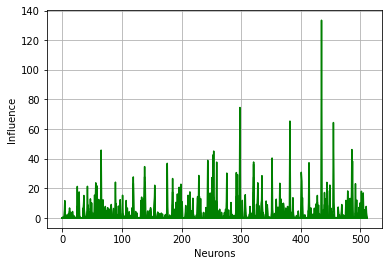

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

X = list(int(i) for i in range(0, 512))
# Initialize the lists for X and Y
    #plt.bar(X, Y, color='g')
plt.xlabel("Neurons")
plt.ylabel("Influence")
# plt.xlim(-0.5, 100)
# plt.ylim(-0.5, 100)
for i in range(50):
  plt.plot(X, influence[i][0:512], color = 'g')
    # plt.plot(X, Y, color = 'g')
plt.xticks(rotation = 0)
plt.grid()
    # plt.savefig('dataset_and_generated_graph/same_resolution/plot'+str(i)+'.png', dpi=500, bbox_inches='tight')
plt.show()

Generate perturbed images